### Phase analysis

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/phase_coupling_analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycircular
import seaborn as sns
import xarray as xr
from frites.conn import conn_reshape_undirected
from scipy.signal import find_peaks
from scipy.stats import circmean, circstd, circvar
from sklearn.metrics import euclidean_distances
from tqdm import tqdm

from src.signal.surrogates import trial_swap_surrogates
from src.util import _extract_roi

In [3]:
def circular_hist(
    ax, x, bins=16, density=True, offset=0, gaps=True, fill=False, alpha=0.3, color="b"
):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x + np.pi) % (2 * np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins + 1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area / np.pi) ** 0.5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(
        bins[:-1],
        radius,
        zorder=1,
        align="edge",
        width=widths,
        edgecolor="k",
        fill=fill,
        linewidth=1,
        alpha=alpha,
        color=color,
    )

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [4]:
def detect_peak_frequencies(power=None, prominence=0.01, verbose=False):

    assert power.ndim == 2
    assert isinstance(power, xr.DataArray)

    roi, freqs = power.roi.data, power.freqs.data
    n_roi = len(roi)

    rois = []
    peak_freqs = []
    peak_prominences = []

    __iter = range(n_roi)
    for i in tqdm(__iter) if verbose else __iter:
        peak_index, peak_info = find_peaks(power[i, :], prominence=prominence)
        peak_freqs += [freqs[peak_index]]
        peak_prominences += [peak_info["prominences"]]
        rois += [[roi[i]] * len(peak_index)]

    return peak_freqs, peak_prominences, rois

#### Load data

In [6]:
DATA_PATH = os.path.expanduser(
    "/home/vinicius/funcog/phaseanalysis/Results/lucy/141017"
)

average_power_epochs = xr.load_dataarray(os.path.join(DATA_PATH, "average_power.nc"))
# average_power = xr.load_dataarray(
#    os.path.join(DATA_PATH, "average_power_whole_trial.nc")
# )
power_time_series = xr.load_dataarray(
    os.path.join(DATA_PATH, "power_time_series_band_1_surr_False.nc")
)
phase_time_series = xr.load_dataarray(
    os.path.join(DATA_PATH, "phase_time_series_band_1_surr_False.nc")
)
phi_series = xr.load_dataarray(
    os.path.join(DATA_PATH, "phase_difference_time_series_band_1_surr_False.nc")
)

In [7]:
wmd = pd.read_excel(
    "/home/vinicius/Documents/WhiteMatterDistance.xlsx", index_col=0
).fillna(0)

/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [8]:
# White matter distances

pairs = phi_series.roi.values

rois_ch_s, rois_ch_t = _extract_roi(pairs, "-")

_, rois_s = _extract_roi(rois_ch_s, "_")
_, rois_t = _extract_roi(rois_ch_t, "_")

wmd_pairs = []
for s, t in zip(rois_s, rois_t):
    wmd_pairs += [wmd.loc[wmd.index == s, wmd.columns == t].values]

wmd_pairs = xr.DataArray(
    np.hstack(wmd_pairs).squeeze(), dims=("roi"), coords={"roi": pairs}, name="wmd"
)

In [9]:
import numpy as np

# Define the matrix using ranges where necessary
xy_grid_lucy = [
    [0, 0, 0, 0, 0, 0] + list(range(248, 253)),
    [0, 0, 0, 0, 0] + list(range(242, 248)),
    [0, 0, 0] + list(range(234, 242)),
    [0, 0] + list(range(225, 234)),
    [0, 0] + list(range(216, 225)),
    [0] + list(range(206, 216)),
    list(range(195, 206)),
    list(range(184, 195)),
    list(range(173, 184)),
    list(range(162, 173)),
    list(range(151, 162)),
    list(range(140, 151)),
    list(range(129, 140)),
    list(range(118, 129)),
    list(range(107, 118)),
    list(range(96, 107)),
    list(range(85, 96)),
    list(range(74, 85)),
    [0] + list(range(64, 74)),
    [0, 0] + list(range(55, 64)),
    [0, 0] + list(range(46, 55)),
    [0, 0] + list(range(37, 46)),
    [0, 0, 0] + list(range(29, 37)),
    [0, 0, 0] + list(range(21, 29)),
    [0, 0, 0, 0, 0] + list(range(15, 21)),
    [0, 0, 0, 0, 0] + list(range(9, 15)),
    [0, 0, 0, 0, 0, 0, 0] + list(range(5, 9)),
    [0, 0, 0, 0, 0, 0, 0] + list(range(1, 5)),
]

# Convert to NumPy array and transpose
xy_grid_lucy = np.array(xy_grid_lucy).T

In [10]:
power_time_series.attrs["xp"] = np.zeros(power_time_series.sizes["roi"])
power_time_series.attrs["yp"] = np.zeros(power_time_series.sizes["roi"])

for pos, c in enumerate(power_time_series.attrs["channels_labels"]):
    x, y = np.where(xy_grid_lucy == c)
    power_time_series.attrs["xp"][pos] = x[0] * 2.3
    power_time_series.attrs["yp"][pos] = y[0] * 2.3

In [11]:
xyz = np.stack(
    (
        power_time_series.attrs["xp"],
        power_time_series.attrs["yp"],
        power_time_series.attrs["z"][power_time_series.attrs["indch"]] / 1000,
    ),
    axis=1,
)

In [12]:
ed = pd.DataFrame(
    euclidean_distances(xyz),
    index=power_time_series.roi.data,
    columns=power_time_series.roi.data,
)

In [13]:
# White matter distances

pairs = phi_series.roi.values

rois_ch_s, rois_ch_t = _extract_roi(pairs, "-")
ed_pairs = []

for s, t in zip(rois_ch_s, rois_ch_t):
    ed_pairs += [ed.loc[ed.index == s, ed.columns == t].values]

ed_pairs = xr.DataArray(
    np.hstack(ed_pairs).squeeze(), dims=("roi"), coords={"roi": pairs}, name="ed"
)

In [14]:
temp = xr.concat((wmd_pairs, ed_pairs), "metrics")

distances = temp.max("metrics")

mask = (ed_pairs < wmd_pairs).values

distances[mask] = temp.isel(roi=mask).mean("metrics")

In [15]:
n_boot = 1000
count = 0


def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


data = power_time_series.values.copy()

trials_surr = []
while count < n_boot:
    out = np.random.choice(
        range(power_time_series.sizes["trials"]),
        size=2,
        replace=True,
    )

    if out[0] == out[1]:
        continue
    else:
        trials_surr += [out]
        count = count + 1
trials_surr = np.stack(trials_surr)

count = 0
channels_surr = []
while count < n_boot:
    out = np.random.choice(
        range(power_time_series.sizes["roi"]),
        size=2,
        replace=True,
    )

    if out[0] == out[1]:
        continue
    else:
        channels_surr += [out]
        count = count + 1
channels_surr = np.stack(channels_surr)

data_surr = []
for c_i, c_j, trial_i, trial_j in tqdm(
    np.concatenate((channels_surr, trials_surr), axis=1)
):
    x = data[trial_i, c_i]
    y = data[trial_j, c_j][..., ::-1]
    # y = shuffle_along_axis(y, axis=1)
    data_surr += [np.stack((x, y))]

data_surr = np.stack(data_surr)

100%|█████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 37481.94it/s]


#### Screening for peaks

In [16]:
bands = {"alpha": [6, 14]}

In [17]:
average_power_norm = average_power_epochs.isel(stim=slice(0, 5)).mean(
    "stim"
) / average_power_epochs.isel(stim=slice(0, 5)).mean("stim").max("freqs")

In [18]:
peak_freqs, peak_prominences, rois = [], [], []

for average_power_norm_ in average_power_norm:
    out1, out2, out3 = detect_peak_frequencies(average_power_norm_, prominence=0)
    peak_freqs += [out1]
    peak_prominences += [out2]
    rois += [out3]

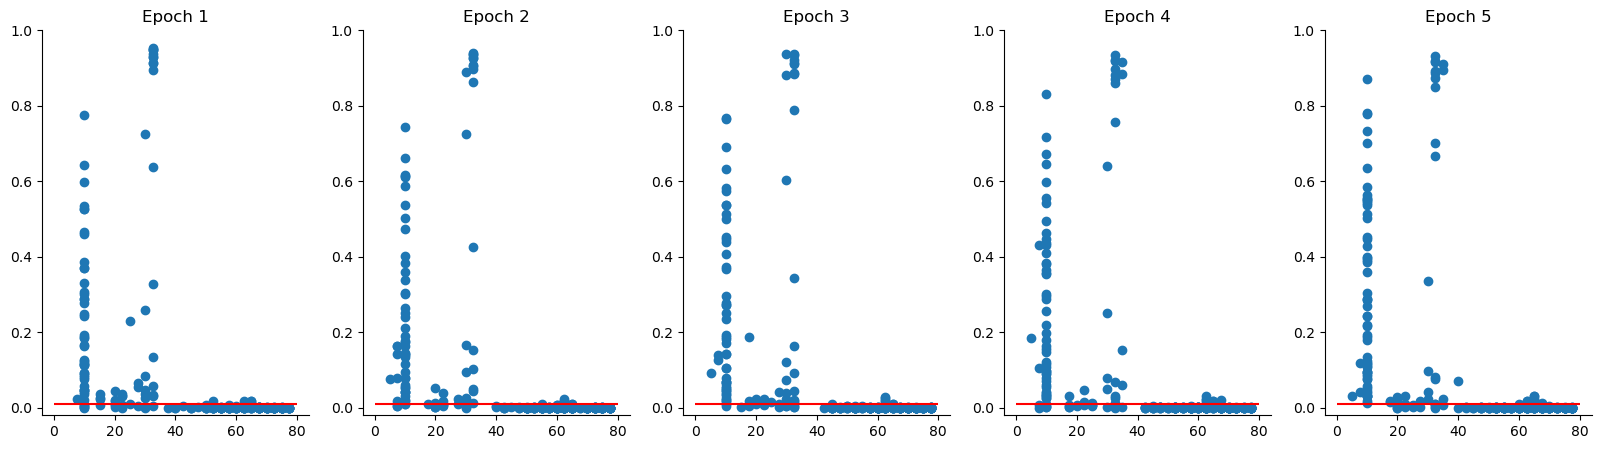

In [19]:
plt.figure(figsize=(20, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.scatter(np.hstack(peak_freqs[i]), np.hstack(peak_prominences[i]))
    plt.hlines(0.01, 0, 80, "r")
    plt.ylim(-0.02, 1)
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.title(f"Epoch {i + 1}")

In [20]:
peak_freqs, peak_prominences, rois = [], [], []

for average_power_norm_ in average_power_norm:
    out1, out2, out3 = detect_peak_frequencies(average_power_norm_, prominence=0.01)
    peak_freqs += [out1]
    peak_prominences += [out2]
    rois += [out3]

In [21]:
def check_peaks(peak_freqs, peak_prominences, rois):

    has_peak = np.zeros((average_power_norm.sizes["roi"], len(bands)), dtype=bool)

    for i in tqdm(range(average_power_norm.sizes["roi"])):
        for peak in peak_freqs[i]:
            for n_band, band in enumerate(bands.keys()):
                if not has_peak[i, n_band]:
                    has_peak[i, n_band] = bands[band][0] <= peak <= bands[band][1]

    has_peak = xr.DataArray(
        has_peak,
        dims=("roi", "bands"),
        coords=(average_power_norm.roi, list(bands.keys())),
    )

    peak_freqs = xr.DataArray(
        np.hstack(peak_freqs),
        dims="roi",
        coords={"roi": np.hstack(rois)},
        name="peak_freq",
    )

    peak_prominences = xr.DataArray(
        np.hstack(peak_prominences),
        dims="roi",
        coords={"roi": np.hstack(rois)},
        name="peak_prom",
    )

    return has_peak

In [22]:
has_peaks = []
for i in range(5):
    has_peaks += [check_peaks(peak_freqs[i], peak_prominences[i], rois[i])]

100%|████████████████████████████████████████████████████| 82/82 [00:00<00:00, 411403.02it/s]


In [23]:
has_peaks = xr.DataArray(
    np.stack(has_peaks, axis=1).squeeze(),
    dims=("roi", "epochs"),
    coords={"roi": average_power_norm.roi.data},
)

In [24]:
rois = phi_series.roi.values
rois_s, rois_t = _extract_roi(rois, "-")

has_peaks_pairs = []

for roi_s, roi_t in zip(rois_s, rois_t):

    has_peaks_pairs += [has_peaks.sel(roi=[roi_s, roi_t]).all("roi").data]

In [25]:
has_peaks_pairs = xr.DataArray(
    has_peaks_pairs, dims=("roi", "epochs"), coords={"roi": rois}
).any("epochs")

In [26]:
# average_power = average_power.isel(roi=has_peaks.any("epochs").values)
power_time_series = power_time_series.isel(roi=has_peaks.any("epochs").values)
phase_time_series = phase_time_series.isel(roi=has_peaks.any("epochs").values)
phi_series = phi_series.isel(roi=has_peaks_pairs.values)

In [27]:
distances = distances.isel(roi=has_peaks_pairs.values)

#### Compute power envelope correlations

In [28]:
from frites.conn.conn_utils import conn_links
from frites.utils import parallel_func


def _pec(w, x_s, x_t, kw_para):

    # define the power envelope correlations
    def pairwise_pec(w_x, w_y):
        # computes the correlation
        return w[:, w_x, :, :] * w[:, w_y, :, :]

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_pec, **kw_para)

    # compute the single trial power envelope correlations
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))


def _cok(w, x_s, x_t, kw_para):

    # define the power envelope correlations
    def pairwise_pec(w_x, w_y):
        # computes the correlation
        x, y = w[:, w_x, :, :], w[:, w_y, :, :]
        k_xyxy = (
            (x * y * x * y).mean(-1)
            - 2 * (x * y).mean(-1) * (x * y).mean(-1)
            - (x * x).mean(-1) * (y * y).mean(-1)
        )
        return k_xyxy / ((np.abs(x) ** 2).mean(-1) * (np.abs(y) ** 2).mean(-1))

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_pec, **kw_para)

    # compute the single trial power envelope correlations
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))


def power_envelope_correlations(power, n_jobs=1, verbose=False):

    # Extract dimensions
    dims = power.dims
    trials, roi, freqs = power.trials.data, power.roi.data, power.freqs.data
    ntrials, nroi, nfreqs, ntimes = power.shape

    roi_gp, roi_idx = roi, np.arange(nroi).reshape(-1, 1)
    (x_s, x_t), roi_p = conn_links(roi_gp, {})
    n_pairs = len(x_s)

    # z-score data and parse to numpy
    z_power = ((power - power.mean("times")) / power.std("times")).data

    kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)

    pec = _pec(z_power, x_s, x_t, kw_para)
    pec = np.stack(pec, axis=1)

    # cok = _cok(z_power, x_s, x_t, kw_para)
    # cok = np.stack(cok, axis=1)

    # conversion
    pec = xr.DataArray(
        pec,
        dims=dims,
        name="pec",
        coords={"trials": trials, "roi": roi_p, "freqs": freqs},
    )
    """
    # conversion
    cok = xr.DataArray(
        cok,
        dims=dims[:-1],
        name="pec",
        coords={"trials": trials, "roi": roi_p, "freqs": freqs},
    )
    """
    return pec  # , cok

In [29]:
from frites.conn.conn_utils import conn_links
from frites.utils import parallel_func


def _int(w, x_s, x_t, kw_para):

    # define the power envelope correlations
    def pairwise_int(w_x, w_y):
        # computes fraciton of events above threshold that intersect
        x = w[:, w_x, :, :]
        y = w[:, w_y, :, :]
        prod = x * y
        norm = np.max([x.sum(-1), y.sum(-1)], axis=0)
        norm = np.where(norm == 0, 1, norm)
        return prod

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_int, **kw_para)

    # compute the single trial power envelope correlations
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))


def power_events_coincidence(power, q, n_jobs=1, verbose=False):

    # Extract dimensions
    dims = power.dims
    trials, roi, freqs = power.trials.data, power.roi.data, power.freqs.data
    ntrials, nroi, nfreqs, ntimes = power.shape

    roi_gp, roi_idx = roi, np.arange(nroi).reshape(-1, 1)
    (x_s, x_t), roi_p = conn_links(roi_gp, {})
    n_pairs = len(x_s)

    quantiles = power.quantile(q, "times")

    z_power = (power >= quantiles).values

    kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)

    pec = _int(z_power, x_s, x_t, kw_para)
    pec = np.stack(pec, axis=1)

    # cok = _cok(z_power, x_s, x_t, kw_para)
    # cok = np.stack(cok, axis=1)
    print(pec.shape)
    # conversion
    pec = xr.DataArray(
        pec,
        dims=dims,
        name="pec",
        coords={"trials": trials, "roi": roi_p, "freqs": freqs},
    )

    return pec

In [30]:
quantiles = power_time_series.quantile(0.6, ("trials", "times"))
z_power = (power_time_series >= quantiles).values

In [31]:
z_power = xr.DataArray(
    z_power, dims=power_time_series.dims, coords=power_time_series.coords
)

In [32]:
x = z_power[:, 0, :, :]
y = z_power[:, 1, :, :]

In [33]:
pec = power_events_coincidence(
    power_time_series, 0.6
)  # power_envelope_correlations(power_time_series)
# pec_surr = power_events_coincidence(
#    power_time_series_surr, 0.6
# )  # power_envelope_correlations(power_time_series_surr)

Defining links (n_roi=61; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/1830 [00:00<?,       ?it/s]

(398, 1830, 1, 2650)


In [34]:
pec_cc = pec  # .mean("times")
# pec_cc_surr = pec_surr  # .mean("times")

NameError: name 'pec_cc_surr' is not defined

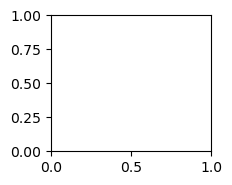

In [35]:
plt.figure(figsize=(12, 6))

roi_p = pec.roi.values

for pos, roi in enumerate(roi_p[:15]):

    ax = plt.subplot(3, 5, pos + 1)

    sns.histplot(
        pec_cc_surr.mean("times").isel(freqs=1),
        stat="probability",
        fill=False,
        color="k",
        ax=ax,
    )

    sns.histplot(
        pec_cc.sel(roi=roi).mean("times").isel(freqs=1),
        stat="probability",
        ax=ax,
        color="b",
    )

    mu = pec_cc.sel(roi=roi).isel(freqs=1).mean()
    mu_surr = pec_cc_surr.isel(freqs=1).mean()

    plt.vlines(0.2, 0, 0.2, "r", "--")

    plt.vlines(mu, 0, 0.2, "g", "--")

    [ax.spines[key].set_visible(False) for key in ["top", "right"]]

    plt.title(f"{roi} ({mu.values:.2f}; {mu_surr.values:.2f})")

plt.tight_layout()

In [36]:
bar = (z_power[100].sel(roi="a9/46D_9") * z_power[100].sel(roi="F6_8")).isel(freqs=1)
barx = z_power[100].sel(roi="a9/46D_9").isel(freqs=1)
bary = z_power[100].sel(roi="F6_8").isel(freqs=1)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
z = (
    power_time_series[100].sel(roi="a9/46D_9") * power_time_series[100].sel(roi="F6_8")
).isel(freqs=1)
z = z >= z.quantile(0.6, "times")

In [36]:
bar = np.where(bar == 0, np.nan, bar)
barx = np.where(barx == 0, np.nan, barx)
bary = np.where(bary == 0, np.nan, bary)
barz = np.where(z == 0, np.nan, z)

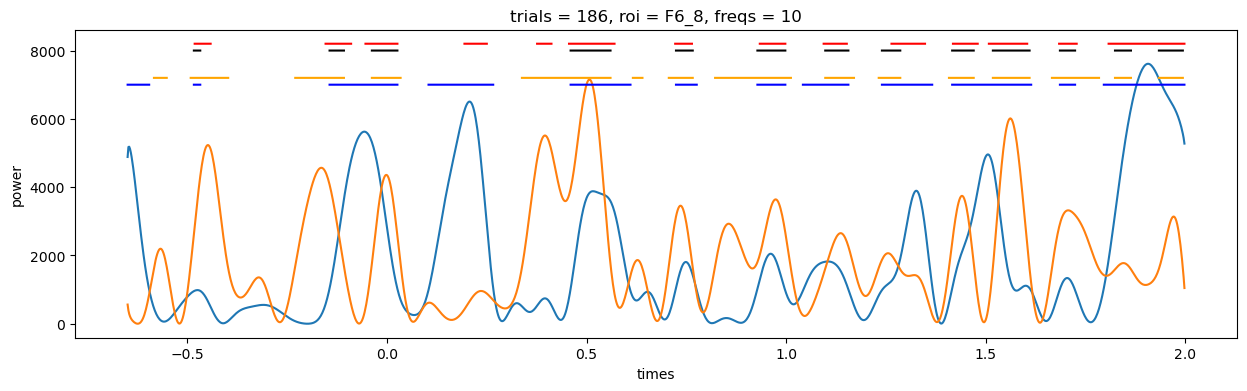

In [37]:
plt.figure(figsize=(15, 4))
power_time_series[100].sel(roi="a9/46D_9").isel(freqs=1).plot()
power_time_series[100].sel(roi="F6_8").isel(freqs=1).plot()
plt.plot(power_time_series.times, bar + 8000, "k")
plt.plot(power_time_series.times, barx + 7000, "b")
plt.plot(power_time_series.times, bary + 7200, "orange")
plt.plot(power_time_series.times, barz + 8200, "red")

#### Surrogates

In [37]:
phase_time_series_surrogate = trial_swap_surrogates(phase_time_series, verbose=True)

100%|███████████████████████████████████████████████████████| 61/61 [00:00<00:00, 172.88it/s]


In [38]:
from frites.conn import conn_io


def _phase_diff(w, x_s, x_t, kw_para):
    def pairwise_phase_diff(w_x, w_y):
        return np.unwrap(w[:, w_x, :, :] - w[:, w_y, :, :])

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_phase_diff, **kw_para)

    # compute the single trial coherence
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))

In [39]:
data, cfg = conn_io(
    phase_time_series_surrogate,
    times="times",
    roi="roi",
    agg_ch=False,
    win_sample=None,
    sfreq=1000,
    verbose=False,
    name="Hilbert Decomposition",
    kw_links={},
)

# Extract variables
x, trials, attrs = data.data, data["y"].data, cfg["attrs"]
times = data["times"].data
x_s, x_t, roi_p, roi = cfg["x_s"], cfg["x_t"], cfg["roi_p"], data["roi"].data

In [40]:
kw_para = dict(n_jobs=20, verbose=True, total=len(x_s))
phi_series_surrogate = np.stack(
    _phase_diff(phase_time_series_surrogate.values, x_s, x_t, kw_para), axis=1
)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.7s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    8.7s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   14.1s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   21.3s
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:   30.0s
[Parallel(n_jobs=20)]: Done 1830 out of 1830 | elapsed:   31.0s finished


#### Compute phase relations

In [41]:
from xarray_einstats.stats import circmean, circstd

In [42]:
crackles = pec

In [43]:
filtered_phi_series = xr.DataArray(
    np.where(~crackles, np.nan, phi_series),
    dims=phi_series.dims,
    coords=phi_series.coords,
)

In [44]:
filtered_phi_series_surr = xr.DataArray(
    np.where(~crackles, np.nan, phi_series_surrogate),
    dims=phi_series.dims,
    coords=phi_series.coords,
)

In [45]:
edges = phi_series.roi.data

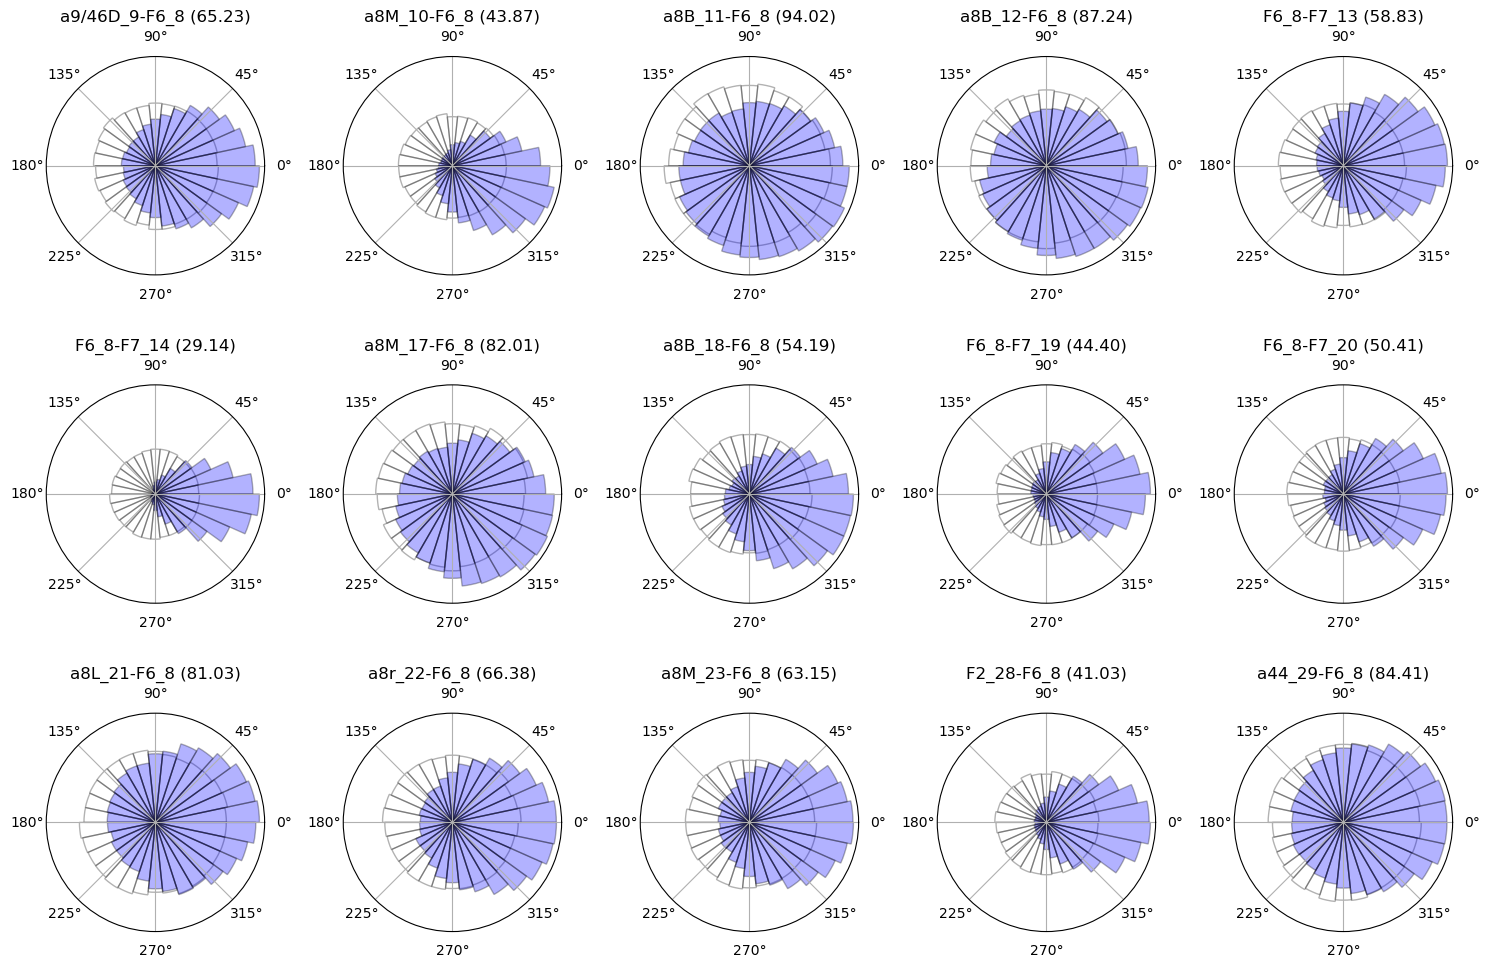

In [46]:
plt.figure(figsize=(15, 10))

for pos in range(15):  # range(phi_series.sizes["roi"]):

    ax = plt.subplot(3, 5, pos + 1, projection="polar")

    out = filtered_phi_series_surr.sel(freqs=10, roi=edges[pos]).data.flatten()
    out = out[~np.isnan(out)]

    circular_hist(ax, out, bins=30, fill=False, color="k")

    out = filtered_phi_series.sel(freqs=10, roi=edges[pos]).data.flatten()
    out = out[~np.isnan(out)]

    circular_hist(
        ax,
        out,
        bins=30,
        fill=True,
    )
    m_1, m_2 = pycircular.stats.periodic_mean_std(out.data)
    # mean = mean * 180 / np.pi
    # std = std * 180 / np.pi
    plt.title(f"{edges[pos]} ({(m_2 * 180 / np.pi):.2f})")

plt.tight_layout()

In [47]:
circular_std = []

for pos in range(phi_series.sizes["roi"]):

    out = filtered_phi_series.sel(freqs=10, roi=edges[pos]).data.flatten()
    out = out[~np.isnan(out)]
    m_1, m_2 = pycircular.stats.periodic_mean_std(out.data)
    circular_std += [m_2 * 180 / np.pi]

circular_std = xr.DataArray(circular_std, dims=("roi"), coords=(phi_series.roi.values,))

In [48]:
mu = circmean(filtered_phi_series, dims="times", nan_policy="omit")
std = circstd(filtered_phi_series, dims="times", nan_policy="omit")

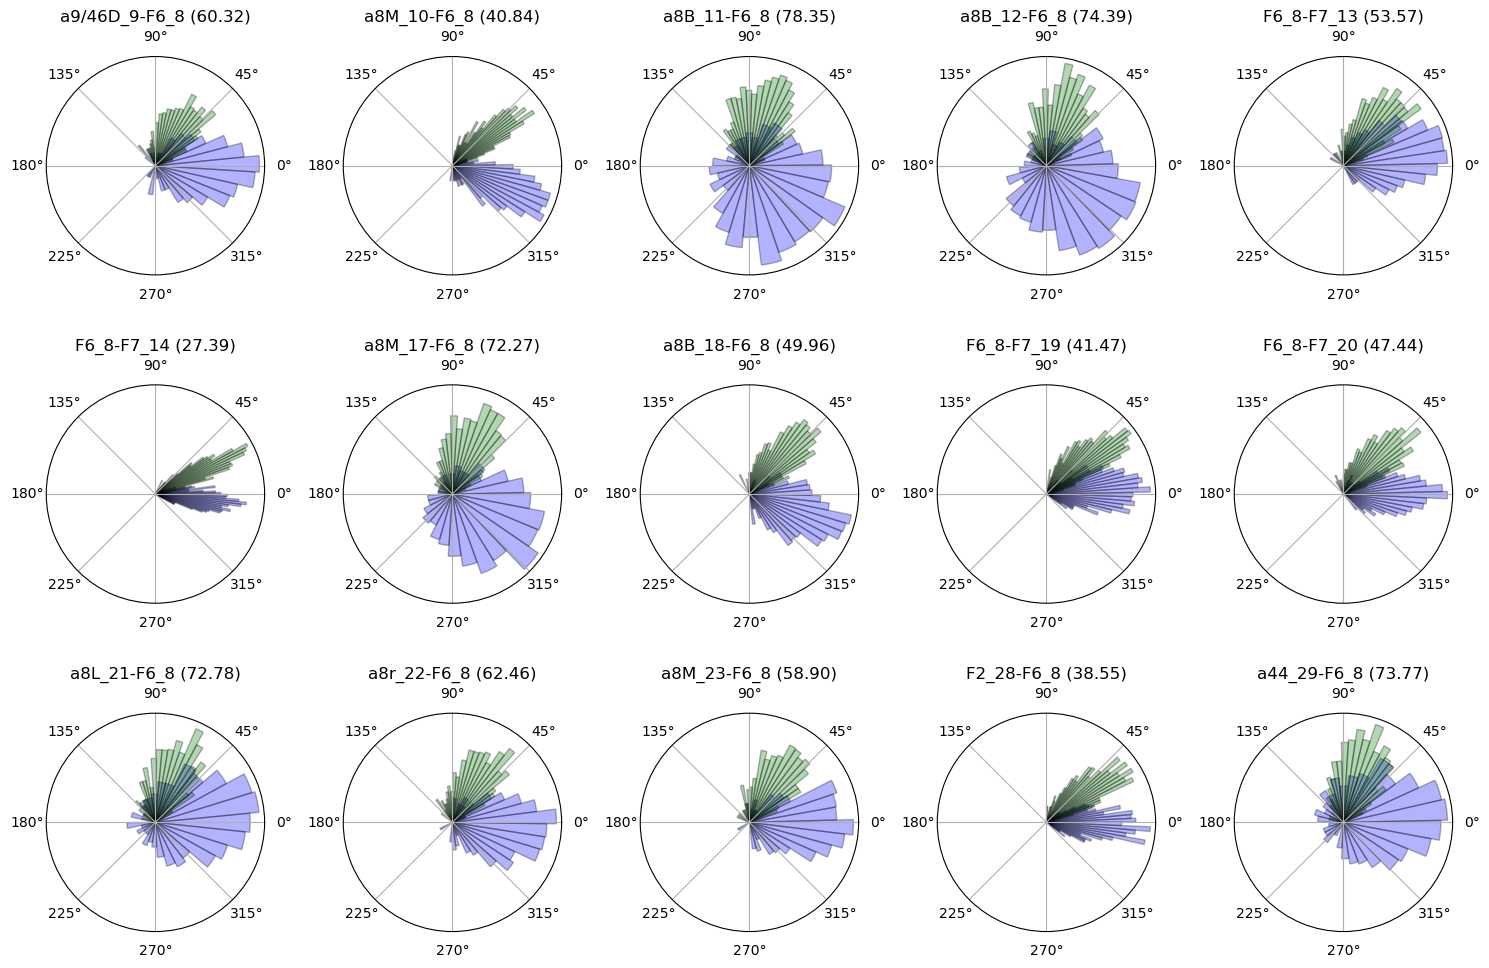

In [49]:
plt.figure(figsize=(15, 10))

for pos in range(15):  # range(phi_series.sizes["roi"]):

    ax = plt.subplot(3, 5, pos + 1, projection="polar")

    _mu = mu.sel(freqs=10, roi=edges[pos]).data.flatten()
    _std = std.sel(freqs=10, roi=edges[pos]).data.flatten()
    # out = out[~np.isnan(out)]

    circular_hist(
        ax,
        _mu,
        bins=30,
        fill=True,
    )

    circular_hist(ax, _std, bins=30, fill=True, color="g")

    m_1, m_2 = pycircular.stats.periodic_mean_std(_std.data)
    # mean = mean * 180 / np.pi
    # std = std * 180 / np.pi
    plt.title(f"{edges[pos]} ({(m_1* 180 / np.pi):.2f})")

plt.tight_layout()

In [53]:
t_match_on = (
    phase_time_series.attrs["t_match_on"] - phase_time_series.attrs["t_cue_on"]
) / phase_time_series.fsample

t_match_on = np.round(t_match_on, 1)

epoch_data = []

for i in range(data.sizes["trials"]):
    stages = [
        [-0.4, 0.0],
        [0, 0.4],
        [0.5, 0.9],
        [0.9, 1.3],
        [t_match_on[i] - 0.4, t_match_on[i]],
    ]

    temp = []

    for t_i, t_f in stages:
        temp += [filtered_phi_series[i].sel(times=slice(t_i, t_f)).data]

    epoch_data += [np.stack(temp, axis=-2)]

In [54]:
epoch_data = xr.DataArray(
    np.stack(epoch_data),
    dims=("trials", "roi", "freqs", "epochs", "time"),
    coords={
        "trials": filtered_phi_series.trials,
        "roi": filtered_phi_series.roi,
    },
    attrs=phase_time_series.attrs,
)

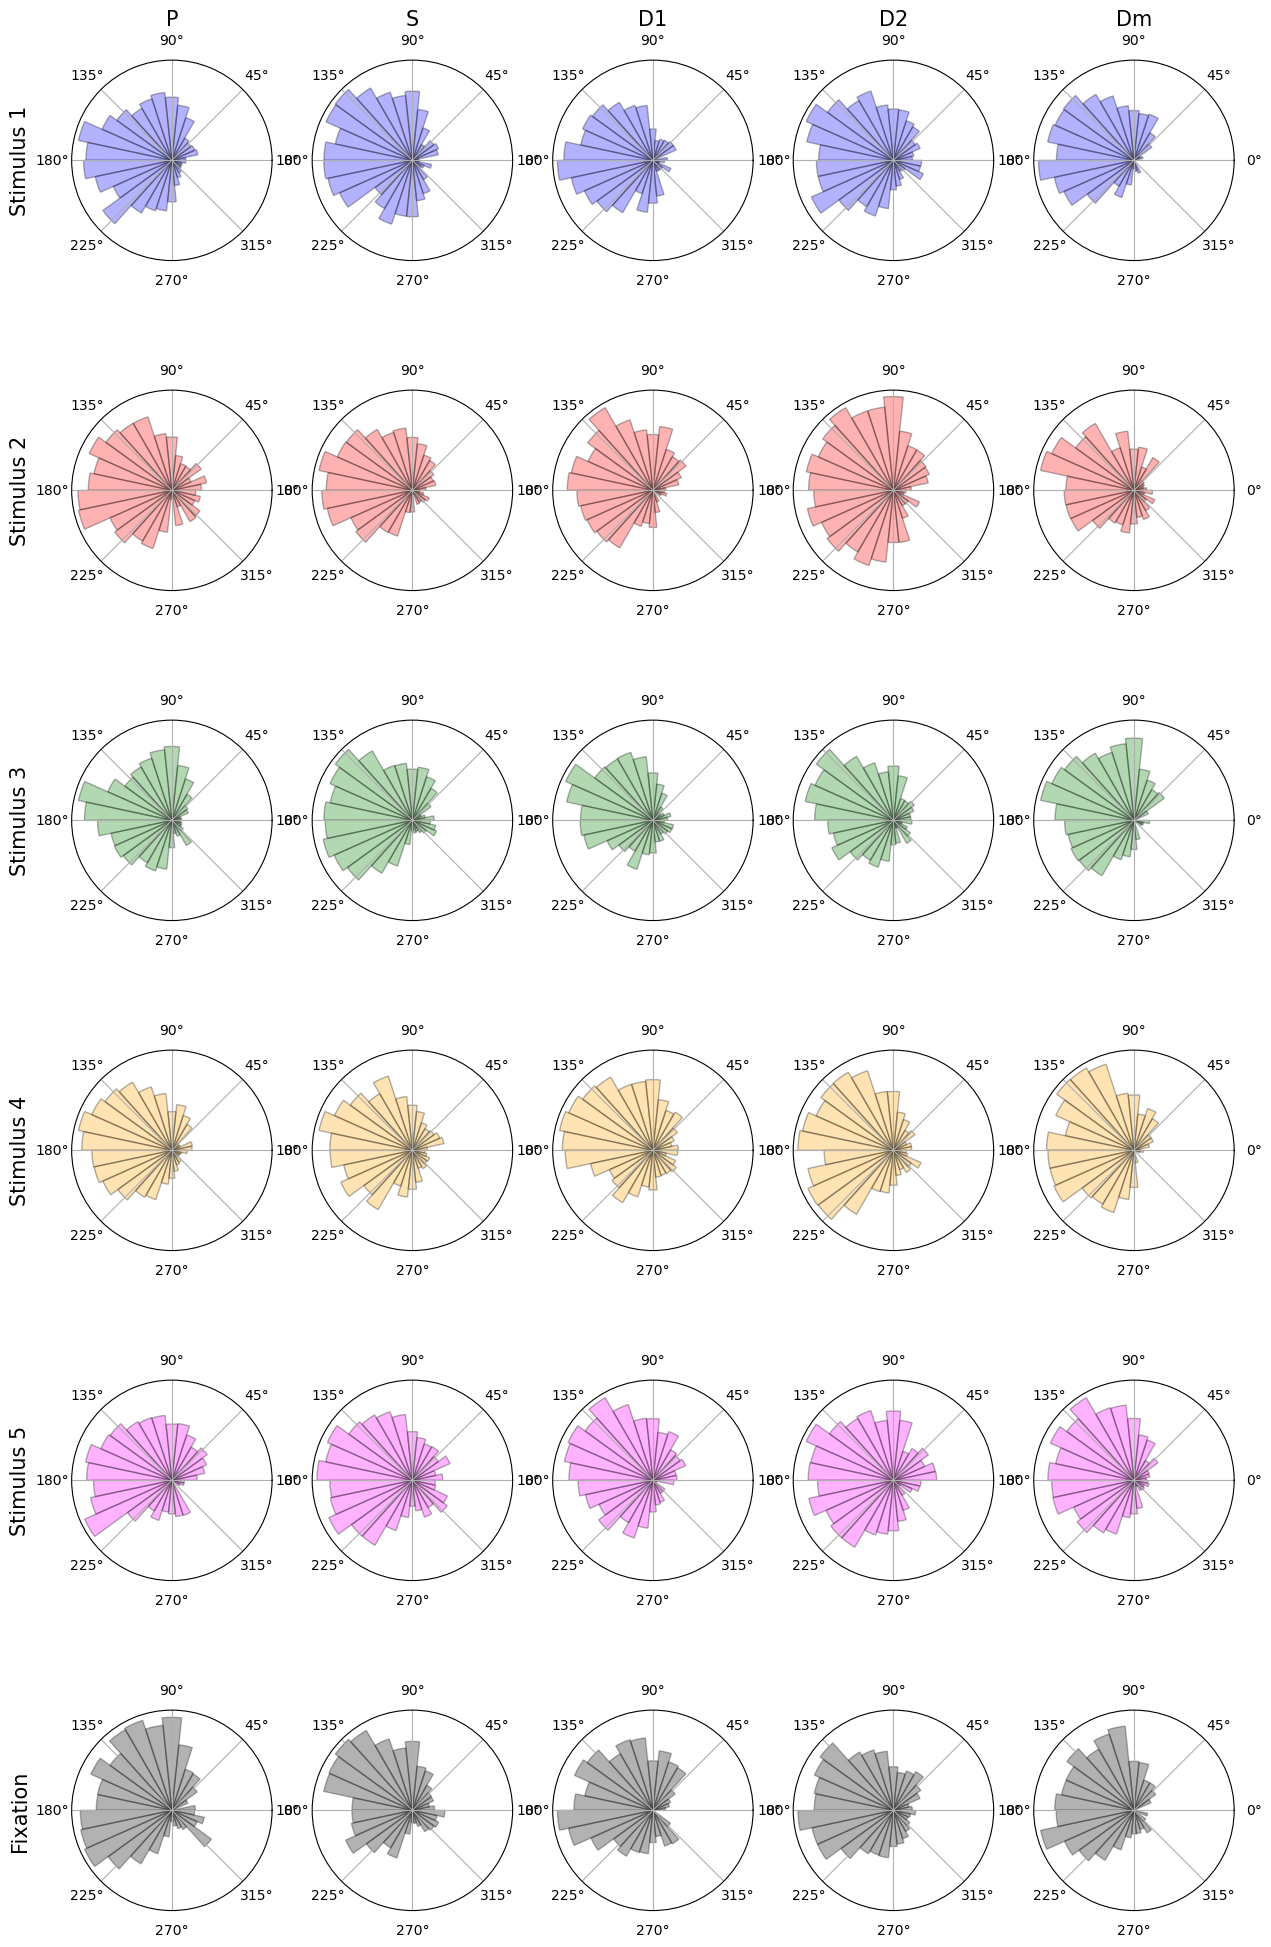

In [62]:
c = ["b", "r", "g", "orange", "magenta", "k"]
epoch = ["P", "S", "D1", "D2", "Dm"]
roi = "a7A_181-a8M_17"
plt.figure(figsize=(15, 25))
pos = 1
for s in range(1, 7):
    for i in range(5):
        ax = plt.subplot(6, 5, pos, projection="polar")
        out = (
            epoch_data.sel(roi=roi, freqs=0, epochs=i)
            .isel(trials=epoch_data.stim == s)
            .data.flatten()
        )
        out = out[~np.isnan(out)]
        circular_hist(ax, out, bins=30, fill=True, color=c[s - 1])
        if s == 1:
            plt.title(epoch[i], fontsize=15)
        if i == 0:
            plt.ylabel(f"Stimulus {s}", fontsize=15, labelpad=30)
            if s == 6:
                plt.ylabel(f"Fixation", fontsize=15, labelpad=30)
        pos = pos + 1

plt.savefig(f"phase_dists_{roi}.png", bbox_inches="tight")

In [63]:
std_ = circmean(std, "trials")

In [65]:
pec_cc.mean(("trials", "times"))

<xarray.DataArray 'pec' (roi: 1830, freqs: 1)> Size: 15kB
array([[0.18249739],
       [0.20981511],
       [0.17420309],
       ...,
       [0.16519674],
       [0.17770456],
       [0.28784963]])
Coordinates:
  * roi      (roi) <U16 117kB 'a9/46D_9-F6_8' 'a8M_10-F6_8' ... 'DP_191-PIP_193'
  * freqs    (freqs) int64 8B 10

Text(0, 0.5, 'Phase variance [°]')

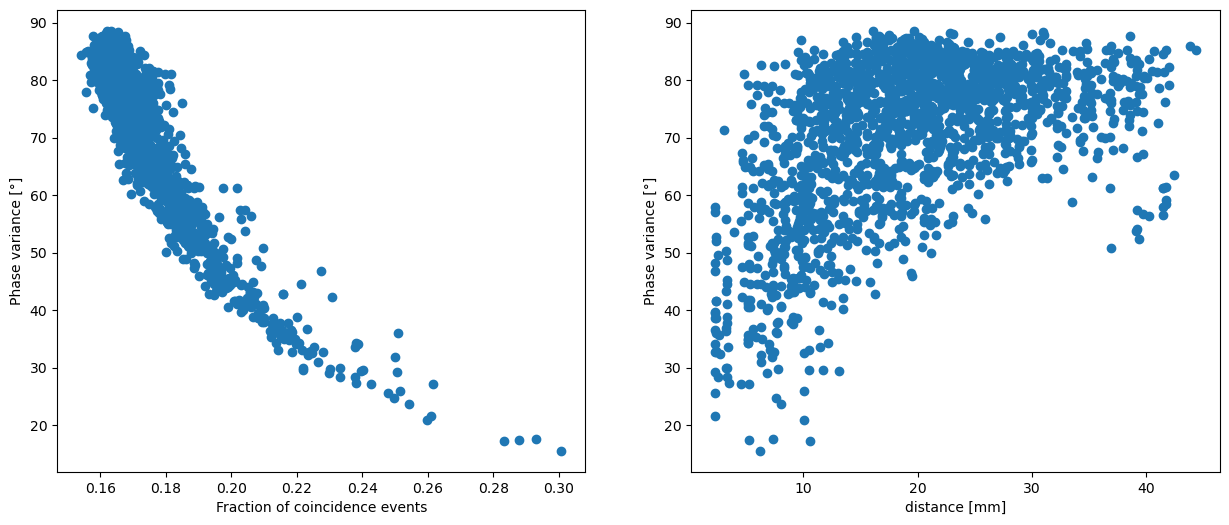

In [67]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.scatter(pec_cc.mean(("trials", "times"))[:, 0], std_[:, 0] * 180 / np.pi)

plt.xlabel("Fraction of coincidence events")
plt.ylabel("Phase variance [°]")

plt.subplot(122)

plt.scatter(distances, std_[:, 0] * 180 / np.pi)

plt.xlabel("distance [mm]")
plt.ylabel("Phase variance [°]")

In [70]:
mask_1 = std_[:, 0] * 180 / np.pi <= 70
mask_2 = distances >= 30

In [71]:
distances.roi.values[np.logical_and(mask_1, mask_2)]

array(['a9/46D_9-TPt_141', 'a7A_181-a9/46D_9', 'a9/46D_9-DP_191',
       'a9/46D_9-PIP_193', 'a7A_181-a8B_11', 'a8B_11-DP_191',
       'a8B_11-PIP_193', 'a7A_181-a8B_12', 'a8B_12-DP_191',
       'a8B_12-PIP_193', 'a7B_121-F7_13', 'a7A_156-F7_13',
       'a7A_181-F7_13', 'DP_191-F7_13', 'F7_13-PIP_193', 'a5_149-F7_14',
       'a7A_156-a8M_17', 'a7A_181-a8M_17', 'a8M_17-DP_191',
       'a8M_17-PIP_193', 'a7A_156-a8B_18', 'a7A_181-a8B_18',
       'a8B_18-DP_191', 'a8B_18-PIP_193', 'a5_149-F7_20',
       'a7A_181-a8L_21', 'a8L_21-DP_191', 'a5_172-F2_28', 'F2_28-V6A_183',
       'a44_29-a7A_181', 'a44_29-DP_191', 'F2_36-V6A_183',
       'a7A_181-a8L_39', 'a8L_39-DP_191', 'a8L_39-PIP_193'], dtype='<U16')

In [72]:
power_time_series.roi

<xarray.DataArray 'roi' (roi: 61)> Size: 2kB
array(['F6_8', 'a9/46D_9', 'a8M_10', 'a8B_11', 'a8B_12', 'F7_13', 'F7_14',
       'a8M_17', 'a8B_18', 'F7_19', 'F7_20', 'a8L_21', 'a8r_22', 'a8M_23',
       'F2_28', 'a44_29', 'F2_36', 'a8L_39', 'a8L_40', 'F2_43', 'F2_44',
       'F2_45', 'F2_54', 'F1_63', 'a3_64', 'a3_65', 'F1_69', 'F1_83', 'F1_84',
       'a2_86', 'F1_92', 'F1_95', 'a1_101', 'a1_103', 'F1_104', 'F1_105',
       'a3_106', 'a7B_110', 'a2_112', 'a1_114', 'a1_115', 'a1_116', 'a3_117',
       'a7B_121', 'a7B_122', 'a5_124', 'a2_125', 'a2_126', 'a1_127', 'a5_136',
       'a2_138', 'TPt_141', 'a5_149', 'a7A_156', 'a5_161', 'DP_168', 'a5_172',
       'a7A_181', 'V6A_183', 'DP_191', 'PIP_193'], dtype='<U8')
Coordinates:
  * roi      (roi) <U8 2kB 'F6_8' 'a9/46D_9' 'a8M_10' ... 'DP_191' 'PIP_193'

#### Phase networks

In [73]:
from frites.plot import plot_conn_circle, plot_conn_heatmap

In [74]:
def WrapToPi(x):
    xwrap = x % 2 * np.pi
    mask = np.abs(xwrap) > np.pi
    xwrap[mask] -= 2 * np.pi * np.sign(xwrap[mask])
    return xwrap

In [76]:
conn_mu = circmean(mu, "trials")[:, 0]

conn_mu = conn_reshape_undirected(WrapToPi(conn_mu) * 180 / np.pi, fill_value=0)

/home/vinicius/Documents/frites/frites/conn/conn_utils.py:520: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'roi' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  da[axis] = pd.MultiIndex.from_arrays(


In [77]:
conn_std = circmean(std, "trials")[:, 0]

conn_std = conn_reshape_undirected(conn_std, fill_value=0)

/home/vinicius/Documents/frites/frites/conn/conn_utils.py:520: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'roi' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  da[axis] = pd.MultiIndex.from_arrays(


In [78]:
pvn = conn_std * 180 / np.pi
pvn = pvn < 70
pvn = np.where(pvn == False, np.nan, pvn)

<Axes: >

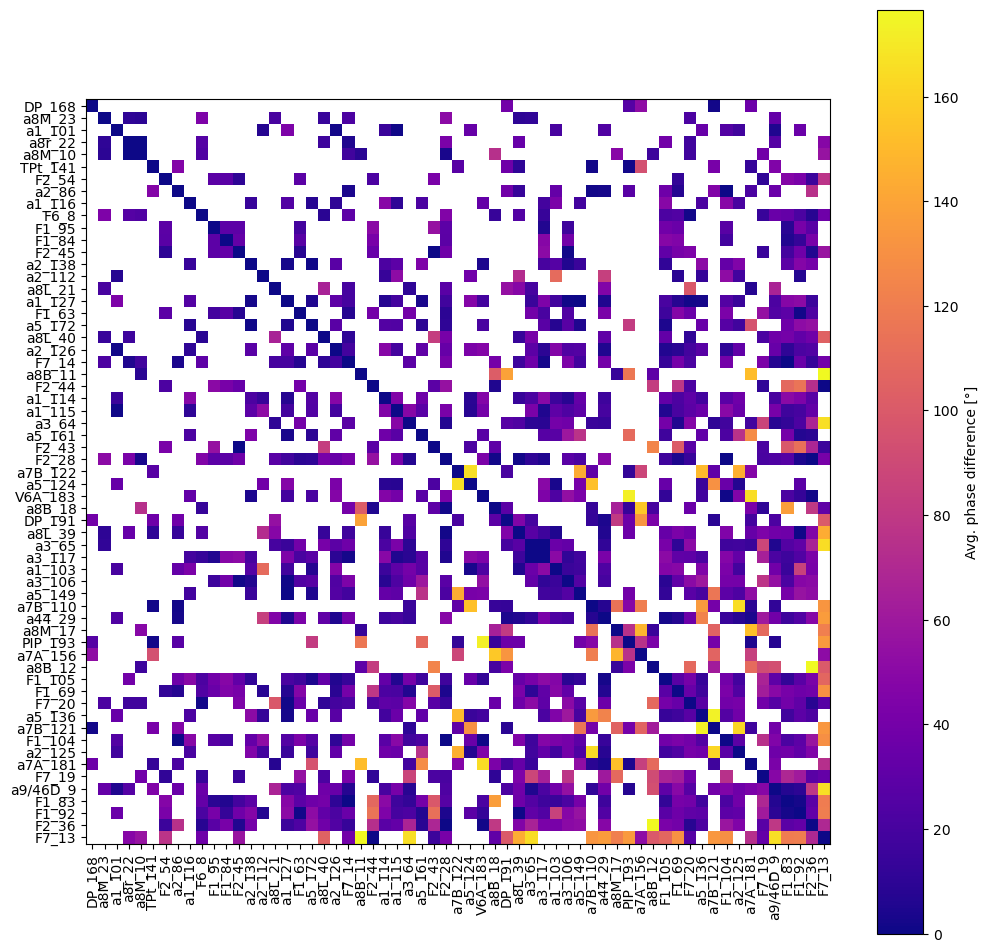

In [79]:
plt.figure(figsize=(12, 12))
ax = plt.subplot(111)
conn = np.abs(conn_mu) * pvn
idx = np.argsort(conn.sum(axis=1).values)
plot_conn_heatmap(
    conn.isel(sources=idx).isel(targets=idx),
    ax=ax,
    cbar_title="Avg. phase difference [°]",
)
# ax = plt.subplot(212)
# plot_conn_heatmap(conn_std * 180 / np.pi, cmap="Greys_r", ax=ax)

#### Dependence on quantile

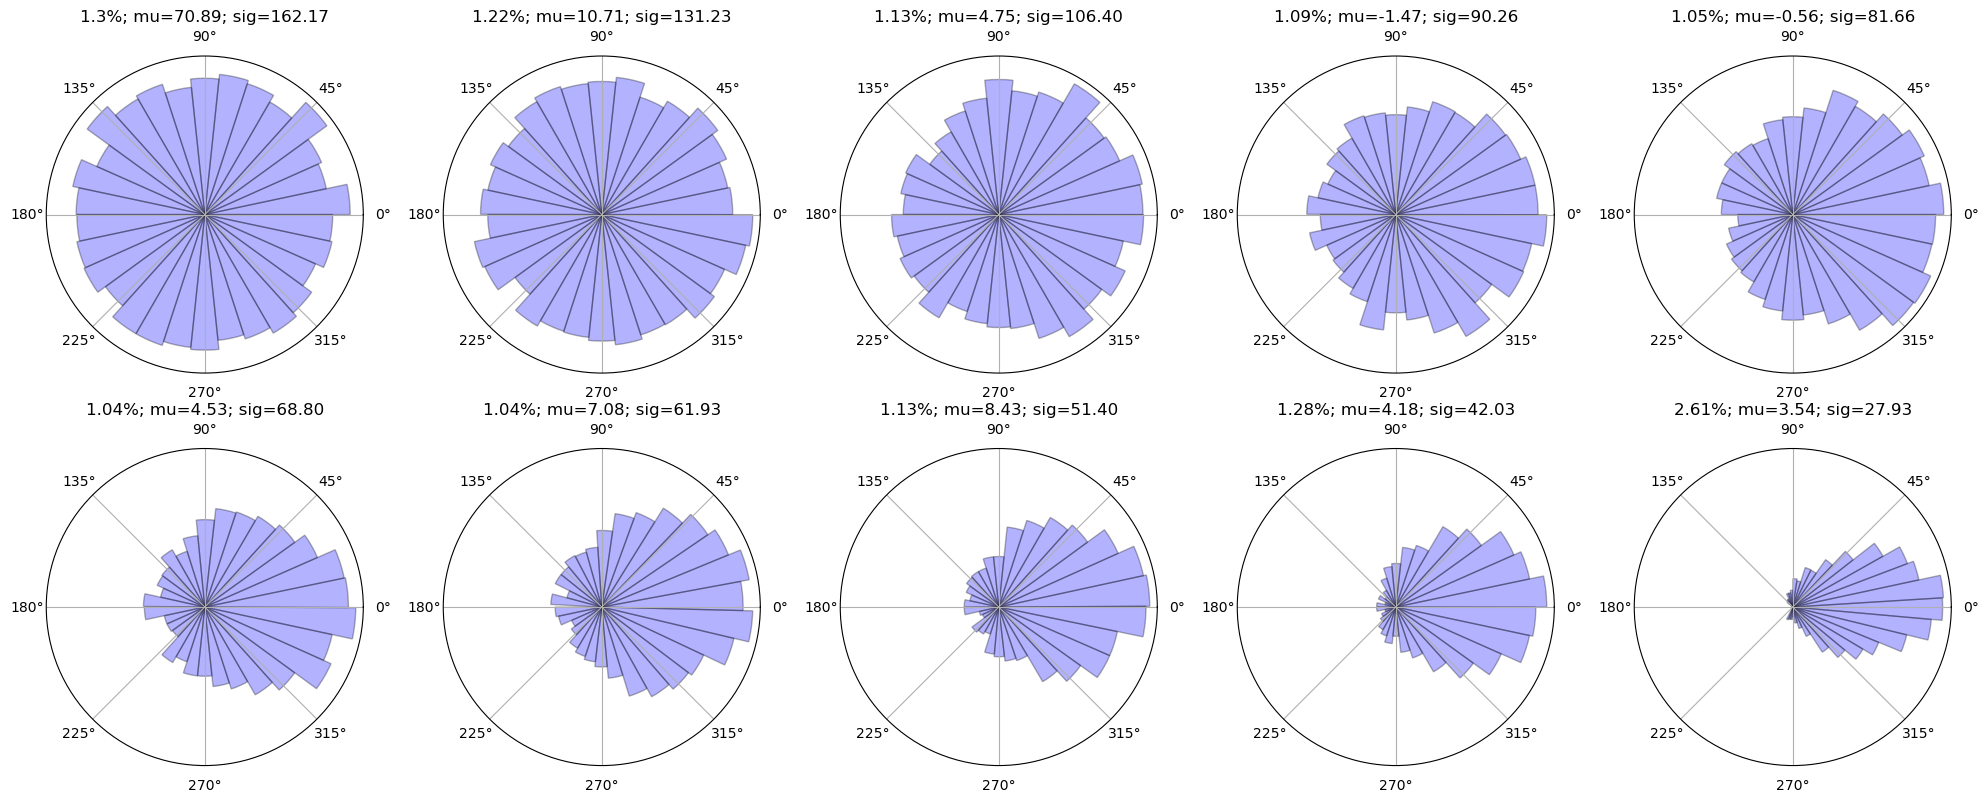

In [113]:
quantiles_l = np.arange(0, 1, 0.1)
quantiles_u = np.arange(0, 1, 0.1) + 0.1

variances = []
plt.figure(figsize=(20, 8))
pos = 0
for q_l, q_u in zip(quantiles_l, quantiles_u):

    lower_thr, upper_thr = power_time_series.quantile(
        q_l, ("trials", "times")
    ), power_time_series.quantile(q_u, ("trials", "times"))

    z_power = np.logical_and(
        power_time_series >= lower_thr, power_time_series < upper_thr
    )

    x = z_power.sel(roi="F6_8")
    y = z_power.sel(roi="F7_19")

    filtered_phi_series = xr.DataArray(
        np.where(~(x * y), np.nan, phi_series.sel(roi="F6_8-F7_19")),
        dims=phi_series.sel(roi="F6_8-F7_19").dims,
        coords=phi_series.sel(roi="F6_8-F7_19").coords,
    )

    out = filtered_phi_series.sel(freqs=10).data.flatten()
    out = out[~np.isnan(out)]

    ax = plt.subplot(2, 5, pos + 1, projection="polar")
    circular_hist(
        ax,
        out,
        bins=30,
        fill=True,
    )
    pos = pos + 1

    m_1, m_2 = pycircular.stats.periodic_mean_std(out)

    m_1 = m_1 * 180 / np.pi
    m_2 = m_2 * 180 / np.pi

    fraction = np.round((x * y).mean().values * 100, 2)
    plt.title(f"{fraction}%; mu={m_1:.2f}; sig={m_2:.2f}")

    variances += [m_2]
plt.tight_layout()

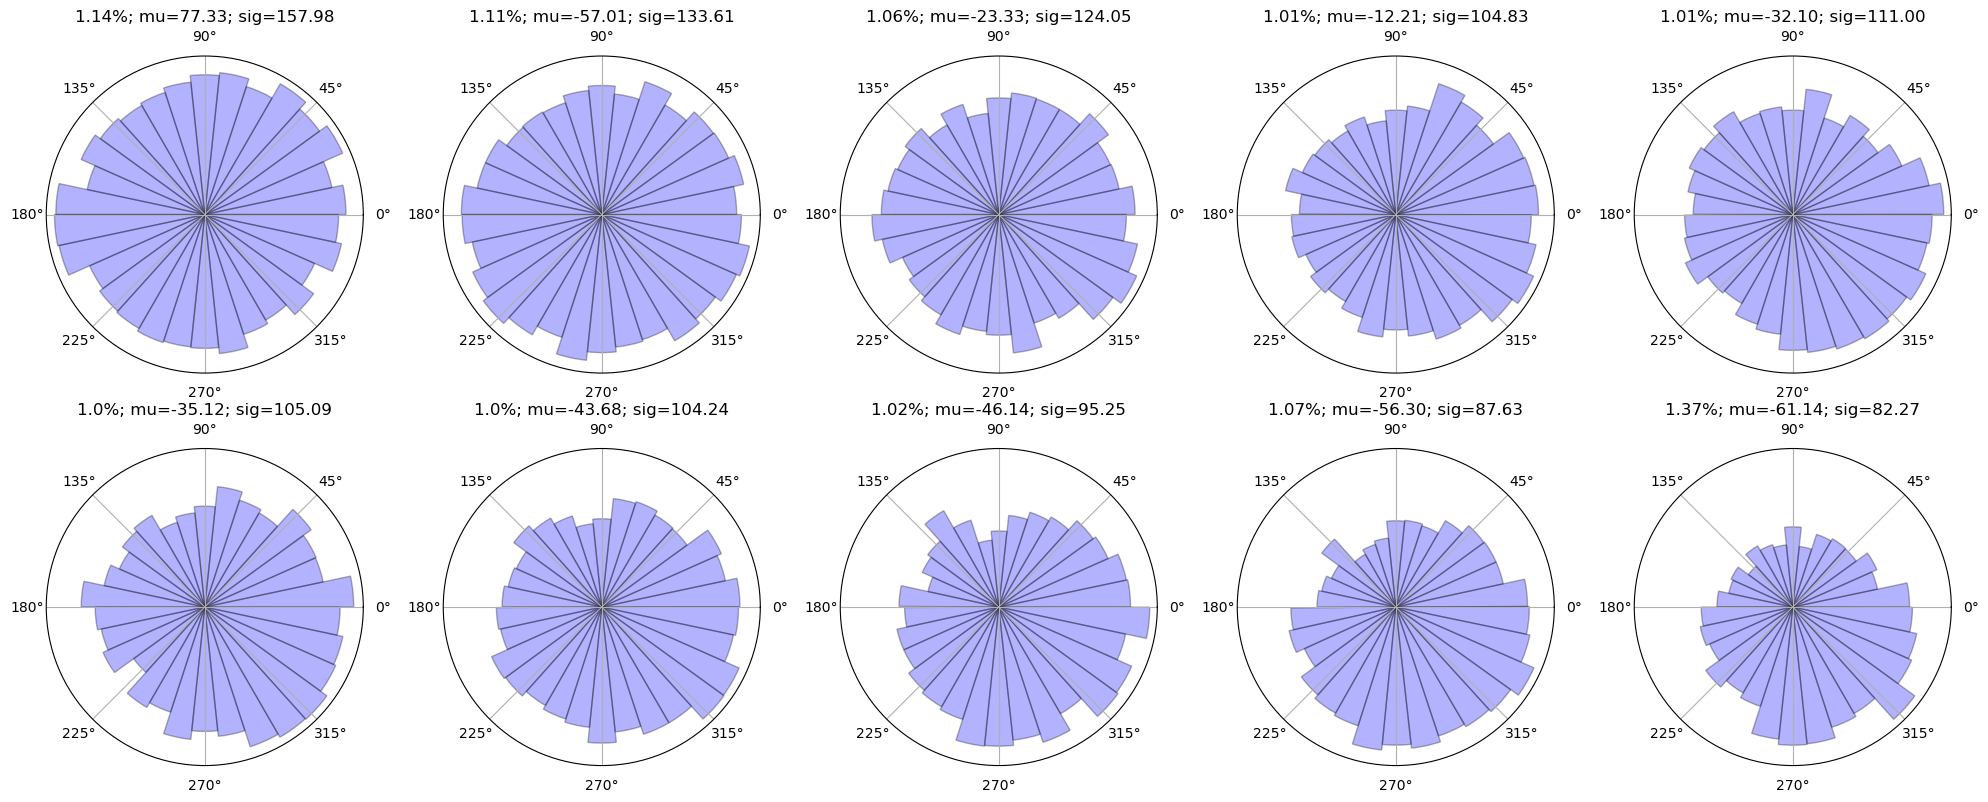

In [114]:
quantiles_l = np.arange(0, 1, 0.1)
quantiles_u = np.arange(0, 1, 0.1) + 0.1

variances_2 = []
plt.figure(figsize=(20, 8))
pos = 0
for q_l, q_u in zip(quantiles_l, quantiles_u):

    lower_thr, upper_thr = power_time_series.quantile(
        q_l, ("trials", "times")
    ), power_time_series.quantile(q_u, ("trials", "times"))

    z_power = np.logical_and(
        power_time_series >= lower_thr, power_time_series < upper_thr
    )

    x = z_power.sel(roi="F6_8")
    y = z_power.sel(roi="a8B_11")

    filtered_phi_series = xr.DataArray(
        np.where(~(x * y), np.nan, phi_series.sel(roi="a8B_11-F6_8")),
        dims=phi_series.sel(roi="a8B_11-F6_8").dims,
        coords=phi_series.sel(roi="a8B_11-F6_8").coords,
    )

    out = filtered_phi_series.sel(freqs=10).data.flatten()
    out = out[~np.isnan(out)]

    ax = plt.subplot(2, 5, pos + 1, projection="polar")
    circular_hist(
        ax,
        out,
        bins=30,
        fill=True,
    )
    pos = pos + 1

    m_1, m_2 = pycircular.stats.periodic_mean_std(out)

    m_1 = m_1 * 180 / np.pi
    m_2 = m_2 * 180 / np.pi

    fraction = np.round((x * y).mean().values * 100, 2)
    plt.title(f"{fraction}%; mu={m_1:.2f}; sig={m_2:.2f}")

    variances_2 += [m_2]
plt.tight_layout()

Text(0.5, 0, 'Interquantile ranges')

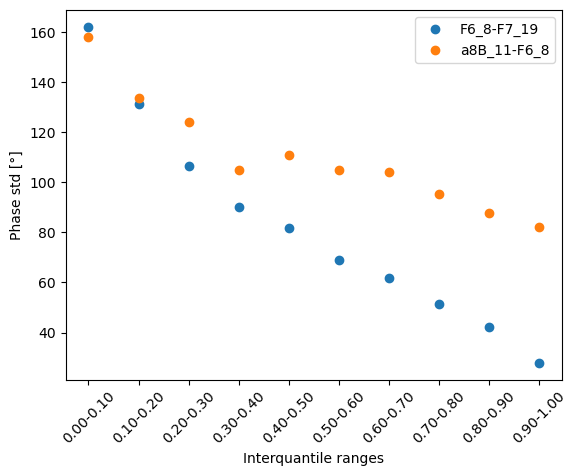

In [115]:
plt.plot(variances, "o", label="F6_8-F7_19")
plt.plot(variances_2, "o", label="a8B_11-F6_8")
plt.legend()
plt.ylabel("Phase std [°]")
x_ticks = [f"{q_l:.2f}-{q_u:.2f}" for q_l, q_u in zip(quantiles_l, quantiles_u)]

plt.xticks(range(len(quantiles_l)), x_ticks, rotation=45)
plt.xlabel("Interquantile ranges")

In [116]:
def variance_circ(edge, power_time_series, phi_series):

    quantiles_l = np.arange(0, 1, 0.1)
    quantiles_u = np.arange(0, 1, 0.1) + 0.1

    variances = np.zeros(len(quantiles_l))

    j = 0
    x_s, x_t = edge.split("-")
    for q_l, q_u in zip(quantiles_l, quantiles_u):

        lower_thr, upper_thr = power_time_series.quantile(
            q_l, ("trials", "times")
        ), power_time_series.quantile(q_u, ("trials", "times"))

        z_power = np.logical_and(
            power_time_series >= lower_thr, power_time_series < upper_thr
        )

        x = z_power.sel(roi=x_s)
        y = z_power.sel(roi=x_t)

        filtered_phi_series = xr.DataArray(
            np.where(~(x * y), np.nan, phi_series.sel(roi=edge)),
            dims=phi_series.sel(roi=edge).dims,
            coords=phi_series.sel(roi=edge).coords,
        )

        out = filtered_phi_series.data.flatten()
        out = out[~np.isnan(out)]

        m_1, m_2 = pycircular.stats.periodic_mean_std(out)

        m_1 = m_1 * 180 / np.pi
        m_2 = m_2 * 180 / np.pi

        fraction = np.round((x * y).mean().values * 100, 2)

        variances[j] = m_2
        j = j + 1
    return variances

In [117]:
edges = phi_series.roi.values
in1, in2 = power_time_series.sel(freqs=10), phi_series.sel(freqs=10)

kw_para = dict(n_jobs=10, verbose=True, total=len(edges))

# define the function to compute in parallel
parallel, p_fun = parallel_func(variance_circ, **kw_para)

# compute the single trial power envelope correlations
out = parallel(p_fun(edge, in1, in2) for edge in edges)

  0%|          |  : 0/903 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   14.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  5.1min
[Parallel(n_jobs=10)]: Done 903 out of 903 | elapsed:  5.9min finished


In [118]:
out = np.stack(out)

Text(0.5, 0, 'Interquantile ranges')

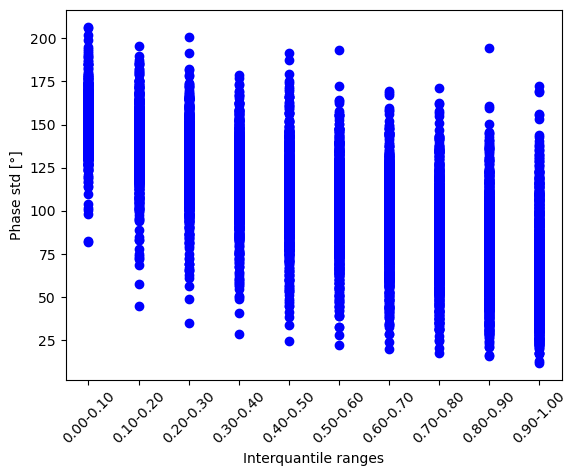

In [119]:
quantiles_l = np.arange(0, 1, 0.1)
quantiles_u = np.arange(0, 1, 0.1) + 0.1
[plt.plot(out_, "bo", lw=0.1) for out_ in out]
plt.ylabel("Phase std [°]")
x_ticks = [f"{q_l:.2f}-{q_u:.2f}" for q_l, q_u in zip(quantiles_l, quantiles_u)]
plt.xticks(range(len(quantiles_l)), x_ticks, rotation=45)
plt.xlabel("Interquantile ranges")

Text(0.5, 1.0, 'Sorted by lowest variance')

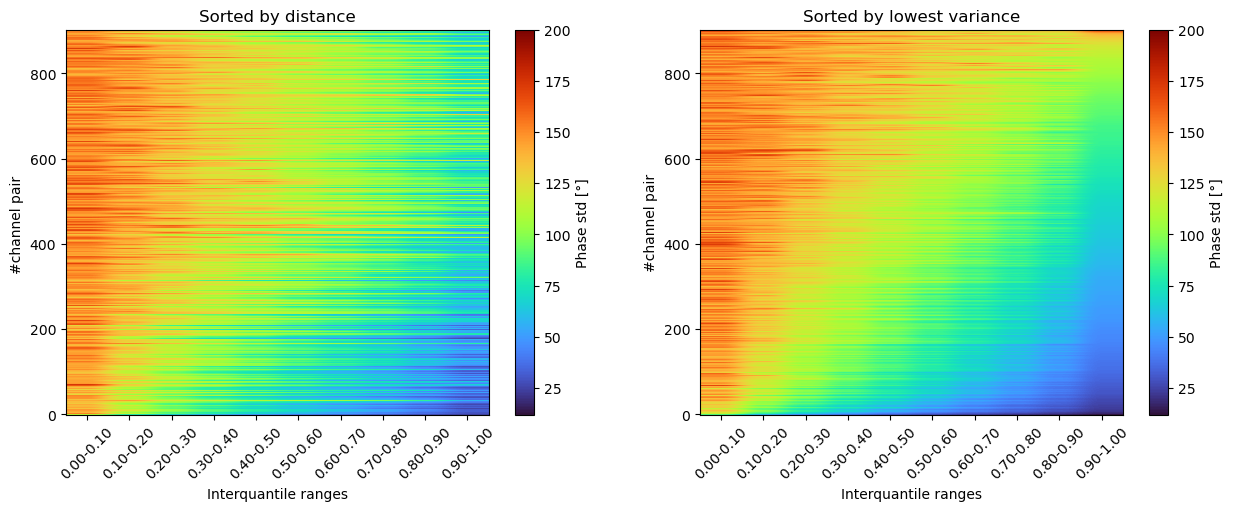

In [125]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
idx = np.argsort(distances)  # np.argsort(out[:, -1])
plt.imshow(out[idx], aspect="auto", cmap="turbo", vmax=200, origin="lower")
plt.colorbar(label="Phase std [°]")
plt.ylabel("#channel pair ")
plt.xticks(range(len(quantiles_l)), x_ticks, rotation=45)
plt.xlabel("Interquantile ranges")
plt.title("Sorted by distance")
plt.subplot(122)
idx = np.argsort(out[:, -1])
plt.imshow(out[idx], aspect="auto", cmap="turbo", vmax=200, origin="lower")
plt.colorbar(label="Phase std [°]")
plt.ylabel("#channel pair")
plt.xticks(range(len(quantiles_l)), x_ticks, rotation=45)
plt.xlabel("Interquantile ranges")
plt.title("Sorted by lowest variance")

In [127]:
from frites.dataset import DatasetEphy
from frites.estimator import GCMIEstimator
from frites.workflow import WfMi

In [131]:
dt = DatasetEphy([phi_series], y="trials", nb_min_suj=1, times="times", roi="roi")

Definition of an electrophysiological dataset
    Dataset composed of 1 subjects / sessions
    At least 1 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)


In [ ]:
mi_type = "cd"
inference = "ffx"
kernel = None
mcp = "fdr"

mi_type = "cd"

estimator = GCMIEstimator(
    mi_type="cd",
    copnorm=True,
    biascorrect=True,
    demeaned=False,
    tensor=True,
    gpu=False,
    verbose=None,
)
wf = WfMi(mi_type, inference, verbose=True, kernel=kernel, estimator=estimator)

kw = dict(n_jobs=30, n_perm=200)
cluster_th = None

mi, pvalues = wf.fit(dt, mcp=mcp, cluster_th=cluster_th, **kw)